In [ ]:
%%capture
!pip install pandas==1.2.4
!pip install pandas-profiling==2.7.1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import pandas_profiling as pp
import re 
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import AdaBoostClassifier
from gensim.parsing.preprocessing import STOPWORDS #import stopword from gensim

import re
import string
import os 
import gensim
import nltk 
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import wordnet


from tensorflow.keras.layers import Embedding 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.text import one_hot

from wordcloud import WordCloud

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Bước 1: Data Understanding

In [ ]:
#đọc dữ liệu bằng pandas
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
df_test = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')

df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
pp.ProfileReport(df_train)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#Bước 2: Data preparation

In [ ]:
#Chọn lại data: chỉ lấy cột OriginalTweet và Sentiment
df_train = df_train[['OriginalTweet', 'Sentiment']]
df_test = df_test[['OriginalTweet', 'Sentiment']]

In [ ]:
#kiểm tra NaN, null, duplicate: không có
df_train.isna().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
df_train.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
df_train.duplicated().sum()

0

In [ ]:
df_test.isna().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
df_test.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
df_test.duplicated().sum()

0

###Xem phân bố cột sentiment:


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

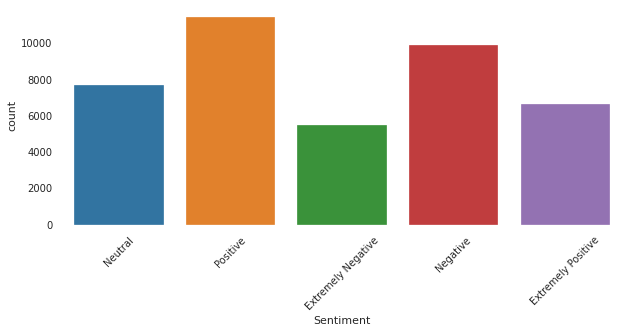

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Sentiment', data=df_train)
plt.xticks(rotation=45)

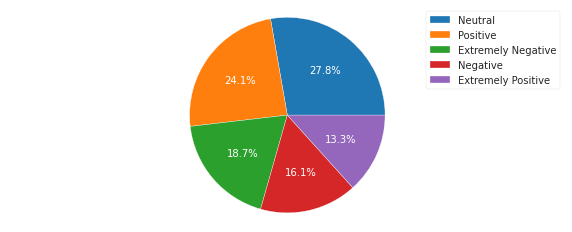

In [ ]:
plt.figure(figsize=(10, 4))
plt.pie(df_train['Sentiment'].value_counts(), labels=df_train['Sentiment'].unique(), autopct='%.1f%%',
        textprops={'color':'w'})
plt.legend(loc='upper right')
plt.axis('equal')
plt.show()

Nhận xét: các nhận xét Positive và Negative chiếm số lượng lớn. Các loại còn lại có số lượng gần như tương đồng

###Xem xét các từ trong OriginalTweet

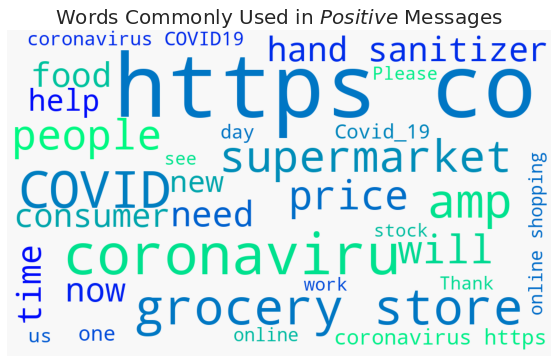

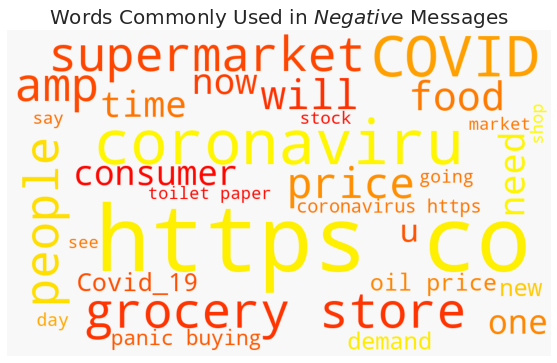

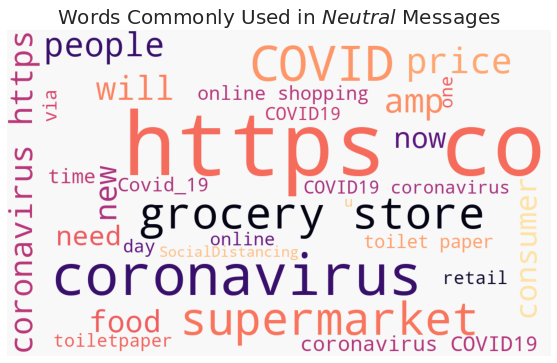

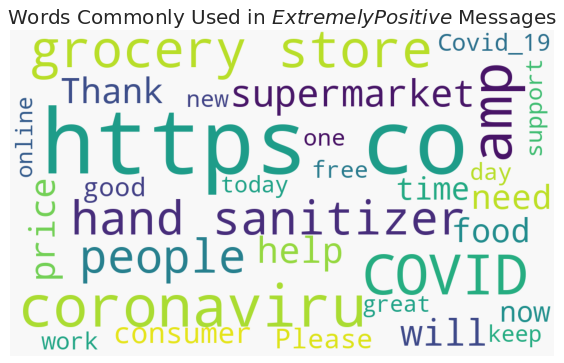

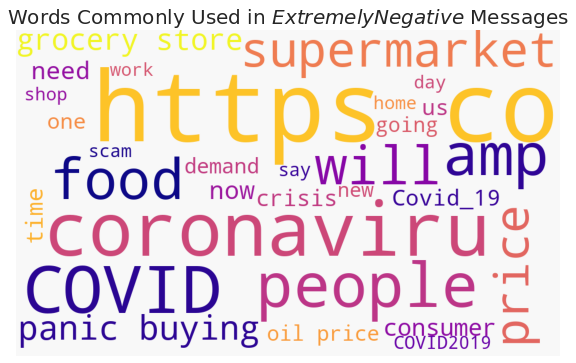

In [ ]:
from wordcloud import WordCloud
for label, cmap in zip(['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative'],
                       ['winter', 'autumn', 'magma', 'viridis', 'plasma']):
  text = df_train.query('Sentiment == @label')['OriginalTweet'].str.cat(sep=' ')
  plt.figure(figsize=(10, 6))
  wc = WordCloud(width=1000, height=600, background_color='#f8f8f8', colormap=cmap, max_words=30)
  wc.generate_from_text(text)
  plt.imshow(wc)
  plt.axis('off')
  plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
  plt.show()

###Data cleaning

In [ ]:
#show cả dòng:
pd.set_option('display.max_colwidth', None)

In [ ]:
df_train.OriginalTweet.head(10)

0                                                                                                                                                                                                                       @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1                                                                                         advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
2                                                                                                                                                                                                   Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
3     My food st

###Loại các ký tự đặc biệt, tokenizer, remove stopword

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
# let's create some of the functions: 
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

#Correct words
def split_dup_words(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"hasn't", "has not", txt)
    txt = re.sub(r"didn't", "did not", txt)
    txt = re.sub(r"wasn't", "was not", txt)
    txt = re.sub(r"weren't", "were not", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    return txt

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = split_dup_words(tweet) #sửa đổi các từ viết tắt
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.split('\W+', tweet)
    tweet = [word for word in tweet if word not in stopwords]

    return tweet


###Map our target with labels

In [ ]:
target_mapping={'Extremely Negative':0, 'Negative':0, 'Neutral':1,
                'Positive':2, 'Extremely Positive':2}

df_train['SentimentMapped']=df_train['Sentiment'].map(lambda x:target_mapping[x])
df_test['SentimentMapped']=df_test['Sentiment'].map(lambda x:target_mapping[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_train.head(5)

,OriginalTweet,Sentiment,SentimentMapped
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,1
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,2
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,2
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,2
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,0


In [ ]:
df_train['OriginalTweetClean'] = df_train['OriginalTweet'].apply(lambda x: preprocess_tweet(x))
df_test['OriginalTweetClean'] = df_test['OriginalTweet'].apply(lambda x: preprocess_tweet(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_train.head()

,OriginalTweet,Sentiment,SentimentMapped,OriginalTweetClean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,1,"[, ]"
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,2,"[advice, talk, neighbours, family, exchange, phone, numbers, create, contact, list, phone, numbers, neighbours, schools, employer, chemist, gp, set, online, shopping, accounts, poss, adequate, supplies, regular, meds, order]"
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,2,"[coronavirus, australia, woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, covid, outbreak, ]"
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,2,"[food, stock, one, empty, please, panic, enough, food, everyone, take, need, stay, calm, stay, safe, ]"
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,0,"[ready, go, supermarket, outbreak, paranoid, food, stock, litteraly, empty, serious, thing, please, panic, causes, shortage, ]"


###Chia dữ liệu train và test 

In [ ]:
X_train = df_train['OriginalTweetClean']
X_test = df_test['OriginalTweetClean']

y_train = df_train['SentimentMapped']
y_test = df_test['SentimentMapped']

In [ ]:
X_train.head()

0                                                                                                                                                                                                                                [, ]
1    [advice, talk, neighbours, family, exchange, phone, numbers, create, contact, list, phone, numbers, neighbours, schools, employer, chemist, gp, set, online, shopping, accounts, poss, adequate, supplies, regular, meds, order]
2                                                                                                                  [coronavirus, australia, woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, covid, outbreak, ]
3                                                                                                                              [food, stock, one, empty, please, panic, enough, food, everyone, take, need, stay, calm, stay, safe, ]
4                                                                               

In [ ]:
#OneHot Encoding the target column
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_test.head()

,0,1,2
0,1,0,0
1,0,0,1
2,0,0,1
3,1,0,0
4,0,1,0


###Tokenize

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#The maximum number of words to be used(most frequent)
MAX_NB_WORDS = 5000
#Max number of words in each Tweet
MAX_SEQUENCE_LENGTH = 50

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train.head(10)

0                                                                                                                                                                                                                                [, ]
1    [advice, talk, neighbours, family, exchange, phone, numbers, create, contact, list, phone, numbers, neighbours, schools, employer, chemist, gp, set, online, shopping, accounts, poss, adequate, supplies, regular, meds, order]
2                                                                                                                  [coronavirus, australia, woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, covid, outbreak, ]
3                                                                                                                              [food, stock, one, empty, please, panic, enough, food, everyone, take, need, stay, calm, stay, safe, ]
4                                                                               

In [ ]:
#Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq[10]

[322,
 3649,
 150,
 353,
 720,
 1492,
 165,
 538,
 2019,
 437,
 65,
 228,
 2762,
 4514,
 643,
 6,
 1]

In [ ]:
#Pad the sequences so each sentence is the same length:
X_train_seq_padded = pad_sequences(X_train_seq, 44) #mỗi pad sequence có 44 phần tử
X_test_seq_padded = pad_sequences(X_test_seq,44)

X_train_seq_padded[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  322, 3649,  150,  353,  720, 1492,
        165,  538, 2019,  437,   65,  228, 2762, 4514,  643,    6,    1],
      dtype=int32)

In [ ]:
print('X_train_seq_padded:', X_train_seq_padded.shape)
print('X_test_seq_padded:', X_test_seq_padded.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train_seq_padded: (41157, 44)
X_test_seq_padded: (3798, 44)
y_train: (41157, 3)
y_test: (3798, 3)


#Áp dụng model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
model=Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1]))
#input_dim: Size of the vocabulary.
#output_dim: Dimension of the dense embedding.

model.add(SpatialDropout1D(0.4))
model.add(LSTM(32, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

# model.add(LSTM(32, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

model.add(LSTM(32, activation='relu', dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 44, 64)            320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 44, 64)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 44, 32)            12416     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 340,835
Trainable params: 340,835
Non-trainable params: 0
__________________________________________________

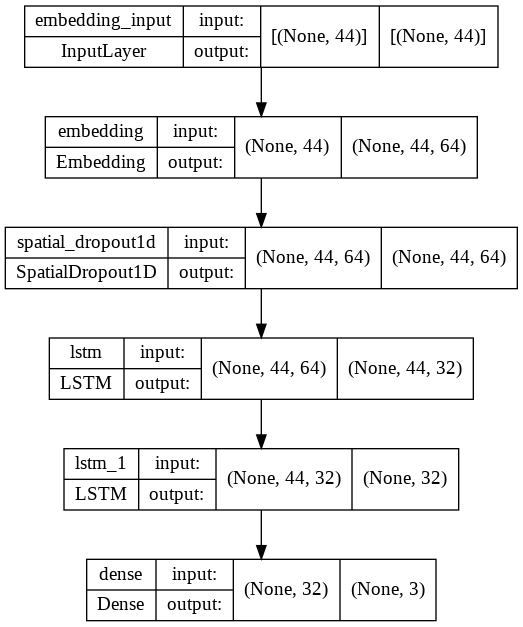

In [ ]:
from tensorflow.keras.utils import plot_model 
from IPython.display import Image 
plot_model(model, to_file='LSTM_model.png', show_shapes=True)
Image(filename='LSTM_model.png')

In [ ]:
#Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Adding an early stopping
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=4, #Stop the model training if the validation accuracy doesnt increase in 4 consecutive Epochs
                   restore_best_weights=True)

In [ ]:
#Fit the RNN
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=100, callbacks =[es],
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/100
1287/1287 [==============================] - 133s 98ms/step - loss: 0.6557 - accuracy: 0.7212 - val_loss: 0.4781 - val_accuracy: 0.8389
Epoch 2/100
1287/1287 [==============================] - 124s 96ms/step - loss: 0.4043 - accuracy: 0.8657 - val_loss: 0.4311 - val_accuracy: 0.8573
Epoch 3/100
1287/1287 [==============================] - 126s 98ms/step - loss: 0.3740 - accuracy: 0.8789 - val_loss: 0.4234 - val_accuracy: 0.8610
Epoch 4/100
1287/1287 [==============================] - 127s 99ms/step - loss: 0.3530 - accuracy: 0.8857 - val_loss: 0.4293 - val_accuracy: 0.8618
Epoch 5/100
1287/1287 [==============================] - 125s 97ms/step - loss: 0.3344 - accuracy: 0.8915 - val_loss: 0.4461 - val_accuracy: 0.8555
Epoch 6/100
1287/1287 [==============================] - 125s 97ms/step - loss: 0.3202 - accuracy: 0.8960 - val_loss: 0.4480 - val_accuracy: 0.8562
Epoch 7/100
1287/1287 [==============================] - 124s 97ms/step - loss: 0.3087 - accuracy: 0.8996 - val_

#Evaluation

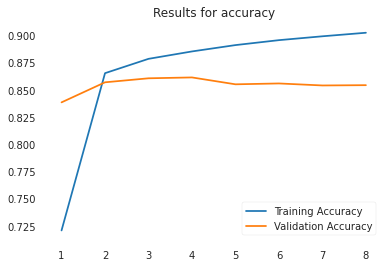

In [ ]:
for i in ['accuracy']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()

In [ ]:
score = model.evaluate(X_test_seq_padded,y_test, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 

Test loss: 0.4292742908000946
Test accuracy: 0.8617693781852722


In [ ]:
y_pred_mlp=model.predict(X_test_seq_padded)

In [ ]:
y_pred_mlp

array([[8.7456489e-01, 3.1747494e-02, 9.3687564e-02],
       [2.4037616e-02, 6.0579404e-03, 9.6990436e-01],
       [5.6052525e-03, 1.9171735e-03, 9.9247760e-01],
       ...,
       [6.7694992e-02, 8.8318056e-01, 4.9124412e-02],
       [9.8955077e-01, 3.9329450e-04, 1.0055884e-02],
       [2.6281814e-03, 1.3091767e-04, 9.9724090e-01]], dtype=float32)

In [ ]:
#save model
from tensorflow.keras.models import load_model
model.save('covid_tweet.h5')
print('save!!!')

save!!!


###Load lại model dự đoán

In [ ]:
# load_model = load_model('covid_tweet.h5')